In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [24]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


In [4]:
L2Loss = function (vec) {
    sum(vec**2) / length(vec)
}

In [22]:
formulas_for_validation = data_frame(
    
    formula = c(
        'price_log ~ GrLivArea',
        'price_log ~ GrLivArea + OverallQual',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea',
        'price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea + KitchenQual',
        'price_log ~ .'
    )
) %>%
mutate(
 formula_num = row_number()
)

formulas_for_validation

formula,formula_num
price_log ~ GrLivArea,1
price_log ~ GrLivArea + OverallQual,2
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,3
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood,4
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea,5
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond,6
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF,7
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition,8
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir,9
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea,10


In [38]:
set.seed(8)

dataset <- 
    combined_dataset %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)
dataset %>% nrow

caret::createDataPartition(
    y = dataset[['price_log']], 
    p = 0.5, 
    list = T, 
    times = 1
)[[1]] -> sample_index

sample_index %>% length

test_y <- dataset[-sample_index, 'price_log'][[1]]
test_y %>% length

dataset[-sample_index, 'price_log'] <- NA
dataset <- house_prices$trans$categ$rating_transform(dataset, price_log)

trainset <- dataset[sample_index,]
testset <- dataset[-sample_index,]
trainset %>% nrow
testset %>% nrow


formulas_for_validation %>%
mutate(
    model = map(formula, ~lm(as.formula(.), data=trainset)),

    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),

    L2_train = map_dbl(model, function (mod) {
        augment <- broom::augment(mod)
        L2Loss(augment[['price_log']] - augment$.fitted)
    }),

    L2_test = map_dbl(model, function (mod) {
        test_predicted <- predict(mod, testset)
        L2Loss(test_predicted - test_y)
    })
) %>%
select(-model) -> report

report

[1] 1458

[1] 730

[1] 728

[1] 730

[1] 728

Warning message in predict.lm(mod, testset):
“prediction from a rank-deficient fit may be misleading”

formula,formula_num,r2,L2_train,L2_test
price_log ~ GrLivArea,1,0.5194971,0.07754011,0.06818203
price_log ~ GrLivArea + OverallQual,2,0.7601174,0.03871052,0.03675421
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,3,0.8075362,0.03105842,0.02931978
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood,4,0.8495874,0.02427250,0.02432850
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea,5,0.8616865,0.02232004,0.02245876
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond,6,0.8740782,0.02032036,0.02071013
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF,7,0.8855278,0.01847271,0.01927105
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition,8,0.8940336,0.01710010,0.01874380
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir,9,0.8984984,0.01637960,0.01770176
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + CentralAir + LotArea,10,0.9024648,0.01573952,0.01690125


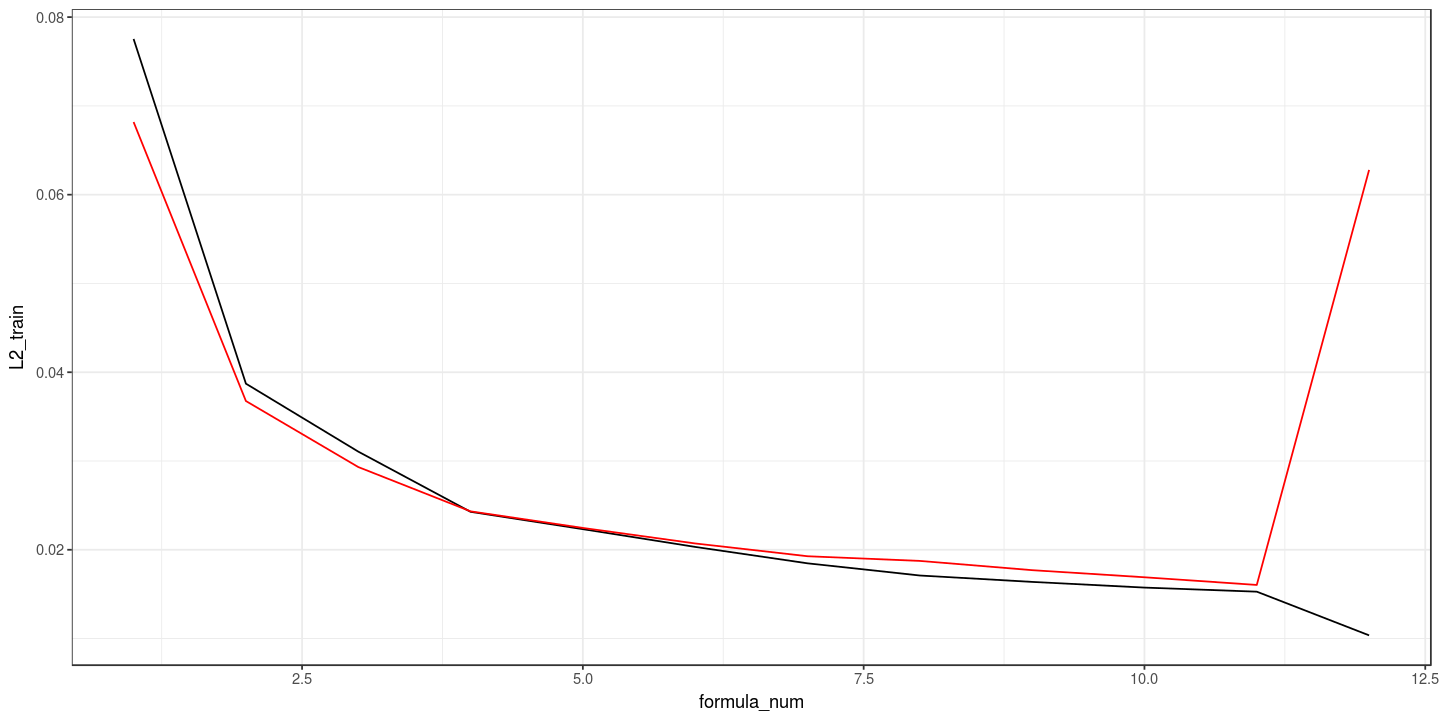

In [39]:
options(repr.plot.width = 12, repr.plot.height = 6)

report %>% 
ggplot() +
geom_line(aes(x=formula_num, y=L2_train, group=1)) +
geom_line(aes(x=formula_num, y=L2_test, group=1), color='red') +
theme_bw()